# Spiral Multiclass Classificaiton

## Introduction

This notebook is meant to practice the multi-class classification using `pytorch`.
THe focus here is to generate a non-linear dataset for training and introducing non linearity.

## Data Preparation

The following data is generated and the source is taken from https://cs231n.github.io/neural-networks-case-study/

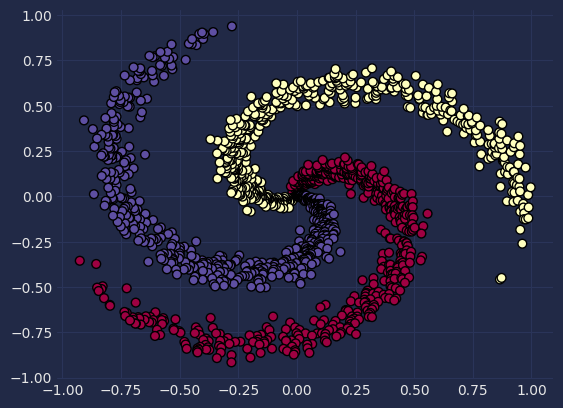

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# just for a dark mode graphs, nothing really useful
import mplcyberpunk
plt.style.use('cyberpunk')

N = 500 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolors='k')
plt.show()

Lets explore the data and see the shapes of X and y.

In [14]:
print(f"Type of X is {type(X)} and it have a shape of {X.shape} and a dtype of {X.dtype}")
print(f"Type of y is {type(y)} and it have s shape of {y.shape} and a dtype of {y.dtype}")

Type of X is <class 'numpy.ndarray'> and it have a shape of (1500, 2) and a dtype of float64
Type of y is <class 'numpy.ndarray'> and it have s shape of (1500,) and a dtype of uint8
